Что сделать?
+ импортировать(!!!), установив свой пакет мутспек в био-енв, класс для парсинга кодонов
+ залить туда функцию парсинга генбанка
+ заменить глупые is_syn & is_ff на стандартный лейбл, там лежит функция ~ get_mut_type
+ получить частоты тринуклеотидов и нуклеотидов простым подсчетом из Ref таблицы
+ воспользоваться уже написанной функцией подсчета мутспека. Ее нужно подправить - добавить вариант когда нужно считать дискретные состояния, а не вероятности, еще один аргумент
+ развернуть мутспек потому что он опять посчитан на L цепи, а надо перевести в H

- Поделить на H & L
- Разложить на подписи

In [2]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from mutspec.utils import (
    read_genbank_ref, calculate_mutspec, CodonAnnotation, 
    possible_codons, possible_sbs12, possible_sbs192,
)

### Observed mutations

In [3]:
##### read observed and merge it with annotation in order to annotate
path_to_obs = "../data/external/CancerDataFromCampbell/mtDNA_snv_Oct2016.txt"
_cols = "position,ref,var,tissue,Annot,Unnamed: 34,Unnamed: 35,is_nonsense".split(",")
ObsAll = pd.read_csv(path_to_obs, sep="\t", usecols=_cols)
ObsAll.head()

,tissue,position,ref,var,Annot,Unnamed: 34,Unnamed: 35,is_nonsense
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",CCAGTGAAAT,GACCTGCCCG,0
1,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",TAAGCCTCCT,ATTCGAGCCG,0
2,BLCA,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",AGTCCTGTAT,CCCTTTTCCT,0
3,BLCA,9078,T,C,"synSNP,MT-ATP6,MT-ATP6,exon1,I184I,5,1;",TATCAACCAT,AACCTTCCCT,0
4,BLCA,9686,T,C,"synSNP,MT-CO3,MT-CO3,exon1,I160I,5,5;",ACCAAATAAT,CAAGCACTGC,0


In [4]:
ObsAll.is_nonsense.value_counts()

0    7330
1     281
Name: is_nonsense, dtype: int64

### "Expected" mutspec 

### Read reference genbank

In [5]:
path_to_gb = "../data/external/NC_012920.1.gb"
Ref = read_genbank_ref(path_to_gb)
print(Ref.shape)
Ref.to_csv("../data/processed/ref_annot.csv", index=None)
Ref.head(4000)

(16569, 9)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...
3995,3996,C,ACA,1,CDS,ND1,690,3,AAC
3996,3997,A,CAT,1,CDS,ND1,691,1,ATT
3997,3998,T,ATT,1,CDS,ND1,692,2,ATT
3998,3999,T,TTA,1,CDS,ND1,693,3,ATT


## Merge only mutations and custom annotation from genbank

In [6]:
ObsAll.head(2)

,tissue,position,ref,var,Annot,Unnamed: 34,Unnamed: 35,is_nonsense
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",CCAGTGAAAT,GACCTGCCCG,0
1,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",TAAGCCTCCT,ATTCGAGCCG,0


In [7]:
Ref.head(2)

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN


In [8]:
coda = CodonAnnotation(2)

In [9]:
def get_alt(ser: pd.Series):
    if not isinstance(ser["Codon"], str):
        return None
    codon = list(ser["Codon"])
    ref_nuc, alt_nuc = ser["ref"], ser["var"]
    pic = ser["PosInCodon"] - 1
    assert codon[pic] == ref_nuc, "reference nucleotide is not tha same as in codon"
    codon[pic] = alt_nuc
    alt_codon = "".join(codon)
    return alt_codon
    
mutations = pd.merge(
    ObsAll[["tissue", "position", "ref", "var", "Annot", "is_nonsense"]], 
    Ref, left_on=["position", "ref"], right_on=["Pos", "Nuc"],
)
mutations["AltCodon"] = mutations.apply(get_alt, axis=1)
mutations["Label"] = mutations.apply(
    lambda s: 0 if s.PosInCodon <= 0 else coda.get_mut_type(
        s.Codon, s.AltCodon, s.PosInCodon - 1)[0], axis=1)

mutations.head()

,tissue,position,ref,var,Annot,is_nonsense,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,AltCodon,Label
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",0,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,None,0
1,PAEN,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",0,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,None,0
2,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",0,6011,T,TTA,1,CDS,COX1,108,3,CTT,CTC,2
3,BLCA,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",0,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0
4,LIRI,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",0,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0


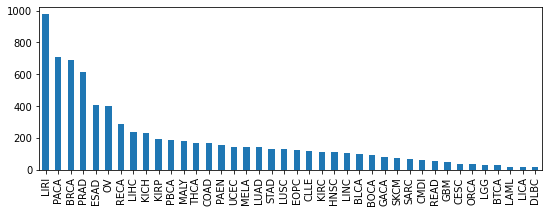

In [10]:
plt.figure(figsize=(9, 3))
mutations.tissue.value_counts().plot.bar();

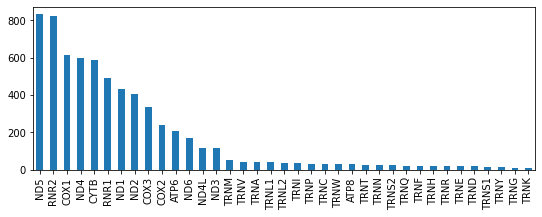

In [11]:
plt.figure(figsize=(9, 3))
mutations.GeneName.value_counts().plot.bar();

In [12]:
mutations.Strand.value_counts()

 1    6209
-1    1359
 0      43
Name: Strand, dtype: int64

In [13]:
mutations.Label.value_counts()

 0    6488
 2     462
 1     373
-1     288
Name: Label, dtype: int64

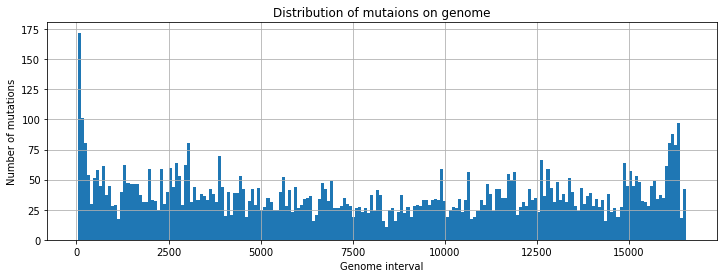

In [14]:
plt.figure(figsize=(12, 4))
plt.title("Distribution of mutaions on genome")
plt.xlabel("Genome interval")
plt.ylabel("Number of mutations")
mutations.Pos.hist(bins=200);

In [15]:
mutations["Mut"] = mutations.Context.str.get(0) + "[" + mutations["ref"] + ">" + mutations["var"] + "]" + mutations.Context.str.get(-1)

### Describe observed mutations

TODO move this func to utils

In [16]:
_mutations_description = mutations[
    (mutations["ref"].isin(list("ACGT"))) &
    (mutations["var"].isin(list("ACGT")))
].groupby(["Label", "GeneName"]).Mut.count().reset_index()
_mutations_description["Label"] = _mutations_description.Label.map(
    {-1: "nns", 0: "other", 1: "syn", 2: "ffd"})

_pivot_mutations = pd.pivot_table(
    _mutations_description,
    values="Mut", index="GeneName", columns="Label", fill_value=0
)[['syn', 'ffd', 'other', 'nns']]

_pivot_mutations

Label,syn,ffd,other,nns
GeneName,,,,
ATP6,20,31,150,5
ATP8,11,2,11,5
COX1,52,72,428,59
COX2,17,28,184,10
COX3,25,22,261,30
CYTB,34,49,450,53
ND1,30,44,337,20
ND2,34,56,285,30
ND3,22,7,83,4


In [17]:
ProtRef = Ref[(Ref.Type == "CDS") & (Ref.Strand == 1)]
ProtRef["SynNum"] = ProtRef.apply(lambda s: coda.get_syn_number(s.Codon, s.PosInCodon - 1), axis=1)
ProtRef

/tmp/ipykernel_30834/2124504442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ProtRef["SynNum"] = ProtRef.apply(lambda s: coda.get_syn_number(s.Codon, s.PosInCodon - 1), axis=1)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,SynNum
3306,3307,A,CAT,1,CDS,ND1,1,1,ATA,0
3307,3308,T,ATA,1,CDS,ND1,2,2,ATA,0
3308,3309,A,TAC,1,CDS,ND1,3,3,ATA,1
3309,3310,C,ACC,1,CDS,ND1,4,1,CCC,0
3310,3311,C,CCC,1,CDS,ND1,5,2,CCC,0
...,...,...,...,...,...,...,...,...,...,...
15882,15883,G,GGG,1,CDS,CYTB,1137,3,TGG,1
15883,15884,G,GGC,1,CDS,CYTB,1138,1,GCC,0
15884,15885,C,GCC,1,CDS,CYTB,1139,2,GCC,0
15885,15886,C,CCT,1,CDS,CYTB,1140,3,GCC,3


### Frequencies counting

In [18]:
nucl_freqs = {
    "all": ProtRef["Nuc"].value_counts().to_dict(),
    "syn": ProtRef.groupby("Nuc")["SynNum"].sum().to_dict(),
    "ff" : ProtRef[ProtRef["SynNum"] == 3].groupby("Nuc")["SynNum"].sum().to_dict(),
}
nucl_freqs

{'all': {'C': 3583, 'A': 3171, 'T': 2767, 'G': 1295},
 'syn': {'A': 2848, 'C': 3515, 'G': 370, 'T': 1151},
 'ff': {'A': 2304, 'C': 2460, 'G': 288, 'T': 789}}

In [19]:
trinucl_freqs = {
    "all": ProtRef["Context"].value_counts().to_dict(),
    "syn": ProtRef.groupby("Context")["SynNum"].sum().to_dict(),
    "ff" : ProtRef[ProtRef["SynNum"] == 3].groupby("Context")["SynNum"].sum().to_dict(),
}
for lbl,freqs in trinucl_freqs.items():
    for cxt in possible_codons:
        if cxt not in freqs:
            trinucl_freqs[lbl][cxt] = 0

    print(lbl)
    print(freqs)
    print()

all
{'CCT': 417, 'CCC': 402, 'CTA': 399, 'CTC': 325, 'ACC': 324, 'CAT': 311, 'CAC': 307, 'AAC': 305, 'CCA': 300, 'ACT': 297, 'TCA': 292, 'ACA': 289, 'CAA': 281, 'TCC': 281, 'ATC': 280, 'TAC': 272, 'AAA': 267, 'AAT': 244, 'ATA': 239, 'TCT': 236, 'TAT': 233, 'TTC': 232, 'TAA': 230, 'ATT': 227, 'CTT': 219, 'GCC': 203, 'TTA': 193, 'AGC': 171, 'TAG': 169, 'TTT': 153, 'GCA': 132, 'TGA': 129, 'CTG': 118, 'CGC': 116, 'CAG': 115, 'GGC': 114, 'GAA': 113, 'GAC': 111, 'GCT': 111, 'ATG': 105, 'AGG': 105, 'TCG': 93, 'CCG': 91, 'ACG': 83, 'AAG': 81, 'AGT': 80, 'CGA': 79, 'AGA': 78, 'TGC': 78, 'GTA': 75, 'GAG': 69, 'GGA': 69, 'TTG': 66, 'GTC': 65, 'GAT': 63, 'TGG': 56, 'CGG': 53, 'CGT': 51, 'TGT': 49, 'GTT': 46, 'GGG': 36, 'GCG': 32, 'GGT': 31, 'GTG': 25}

syn
{'AAA': 78, 'AAC': 63, 'AAG': 49, 'AAT': 35, 'ACA': 107, 'ACC': 114, 'ACG': 52, 'ACT': 173, 'AGA': 4, 'AGC': 13, 'AGG': 5, 'AGT': 10, 'ATA': 31, 'ATC': 17, 'ATG': 27, 'ATT': 45, 'CAA': 303, 'CAC': 210, 'CAG': 276, 'CAT': 237, 'CCA': 468, 'CCC': 

### Calculate mutspec

In [20]:
Mut = mutations[["Pos", "Mut", "Strand", "GeneName", "tissue", "Label"]]
Mut.head()

,Pos,Mut,Strand,GeneName,tissue,Label
0,2680,T[T>C]G,1,RNR2,BLCA,0
1,2680,T[T>C]G,1,RNR2,PAEN,0
2,6011,T[T>C]A,1,COX1,BLCA,2
3,7706,T[G>A]C,1,COX2,BLCA,0
4,7706,T[G>A]C,1,COX2,LIRI,0


In [21]:
mutspec12 = pd.DataFrame({"Mut": possible_sbs12})
mutspec192 = pd.DataFrame({"Mut": possible_sbs192})

for lbl in nucl_freqs:
    ms12 = calculate_mutspec(Mut, nucl_freqs[lbl], lbl, False, False)
    ms12.rename({"MutSpec": f"MutSpec_{lbl}"}, axis=1, inplace=True)
    mutspec12 = pd.merge(mutspec12, ms12[["Mut", f"MutSpec_{lbl}"]], on="Mut")

    ms192 = calculate_mutspec(Mut, trinucl_freqs[lbl], lbl, True, False)
    ms192.rename({"MutSpec": f"MutSpec_{lbl}"}, axis=1, inplace=True)
    mutspec192 = pd.merge(mutspec192, ms192[["Mut", f"MutSpec_{lbl}"]], on="Mut")

### Reverse complement of Mut

In [22]:
translator = str.maketrans("ACGT", "TGCA")

def rev_comp(mut: str):
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [23]:
mutspec12["Mut"] = mutspec12.Mut.str.translate(translator)
mutspec192["Mut"] = mutspec192.Mut.apply(rev_comp)

### Count similarities

In [24]:
print("Labels  \tCos_sim12\tCos_sim192\tEucDist12\tEucDist192")
_lbls = set()
for lbl1 in nucl_freqs:
    _lbls.add(lbl1)
    for lbl2 in nucl_freqs:
        if lbl1 != lbl2 and lbl2 not in _lbls:
            dst12 = spatial.distance.cosine(
                mutspec12[f"MutSpec_{lbl1}"], mutspec12[f"MutSpec_{lbl2}"]
            )
            sim12 = 1 - dst12
            euc12 = spatial.distance.euclidean(
                mutspec12[f"MutSpec_{lbl1}"], mutspec12[f"MutSpec_{lbl2}"]
            )
            dst192 = spatial.distance.cosine(
                mutspec192[f"MutSpec_{lbl1}"], mutspec192[f"MutSpec_{lbl2}"]
            )
            sim192 = 1 - dst192
            euc192 = spatial.distance.euclidean(
                mutspec192[f"MutSpec_{lbl1}"], mutspec192[f"MutSpec_{lbl2}"]
            )
            print(f"{lbl1} & {lbl2}\t{sim12:.2f}\t\t{sim192:.3f}\t\t{euc12:.2f}\t\t{euc192:.3f}")

Labels  	Cos_sim12	Cos_sim192	EucDist12	EucDist192
all & syn	1.00		0.855		0.03		0.104
all & ff	1.00		0.786		0.02		0.140
syn & ff	1.00		0.630		0.02		0.185


In [25]:
print("Excluding zeros (missing observations)\n")
print("Labels  \tCos_sim12\tCos_sim192\tEucDist12\tEucDist192")
_lbls = set()
for lbl1 in nucl_freqs:
    _lbls.add(lbl1)
    for lbl2 in nucl_freqs:
        if lbl1 != lbl2 and lbl2 not in _lbls:
            dst12 = spatial.distance.cosine(
                mutspec12[f"MutSpec_{lbl1}"], mutspec12[f"MutSpec_{lbl2}"]
            )
            sim12 = 1 - dst12
            euc12 = spatial.distance.euclidean(
                mutspec12[f"MutSpec_{lbl1}"], mutspec12[f"MutSpec_{lbl2}"]
            )
            mt_zero = (mutspec192[f"MutSpec_{lbl1}"] > 0) & (mutspec192[f"MutSpec_{lbl2}"] > 0)
            dst192 = spatial.distance.cosine(
                mutspec192[f"MutSpec_{lbl1}"][mt_zero], mutspec192[f"MutSpec_{lbl2}"][mt_zero]
            )
            sim192 = 1 - dst192
            euc192 = spatial.distance.euclidean(
                mutspec192[f"MutSpec_{lbl1}"][mt_zero], mutspec192[f"MutSpec_{lbl2}"][mt_zero]
            )
            print(f"{lbl1} & {lbl2}\t{sim12:.2f}\t\t{sim192:.3f}\t\t{euc12:.2f}\t\t{euc192:.3f}")

Excluding zeros (missing observations)

Labels  	Cos_sim12	Cos_sim192	EucDist12	EucDist192
all & syn	1.00		0.865		0.03		0.100
all & ff	1.00		0.903		0.02		0.109
syn & ff	1.00		0.979		0.02		0.104


### Plot MutSpec

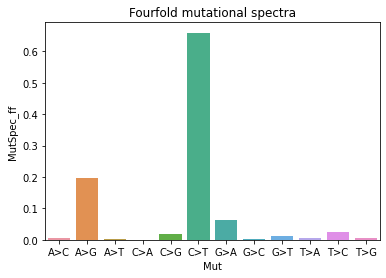

In [26]:
sns.barplot(x="Mut", y="MutSpec_ff", data=mutspec12, order=possible_sbs12)
plt.title("Fourfold mutational spectra")
plt.show()

In [196]:
from itertools import groupby


def _add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black', linewidth=1)
    line.set_clip_on(False)
    ax.add_line(line)


def _label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def _label_group_bar_table(ax, df):
    font = {
        'family': 'cursive',
        'color':  'black',
        'weight': 'normal',
        'size': 7,
    }
    rotation = 90
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        if level == 0:
            rotation = 0
            font['size'] = 12

        pos = 0
        for label, rpos in _label_len(df.index, level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', rotation=rotation,
                    fontdict=font, transform=ax.transAxes)
            if level == 0:
                _add_line(ax, pos*scale, ypos)
            pos += rpos
        if level == 0:
            _add_line(ax, pos*scale, ypos)
        ypos -= .05


def plot_mutspec192(edge_mutspec192, ylabel="MutSpec", title="Mutational spectra", filepath=None):
    edge_mutspec192 = edge_mutspec192.copy()
    edge_mutspec192["Context"] = edge_mutspec192.Mut.apply(lambda x: x[0] + x[2] + x[-1])
    edge_mutspec192["MutBase"] = edge_mutspec192.Mut.apply(lambda x: x[2:5])
    df = edge_mutspec192.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.barplot(x="Mut", y=ylabel, data=edge_mutspec192,
                order=possible_sbs192, errwidth=1, ax=fig.gca())

    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(title)
    _label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath)
    plt.show()

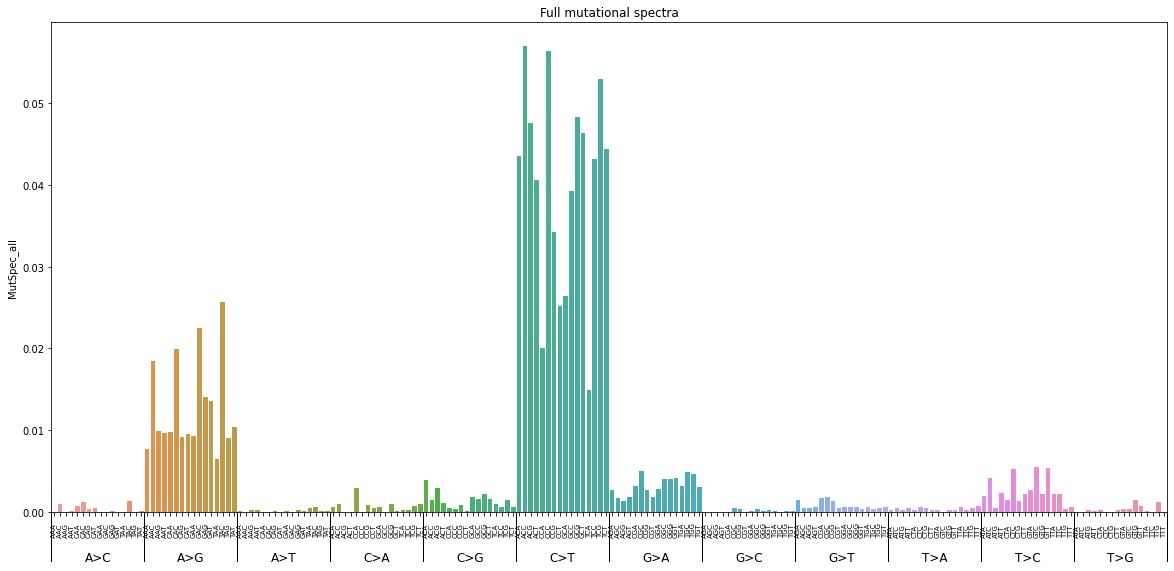

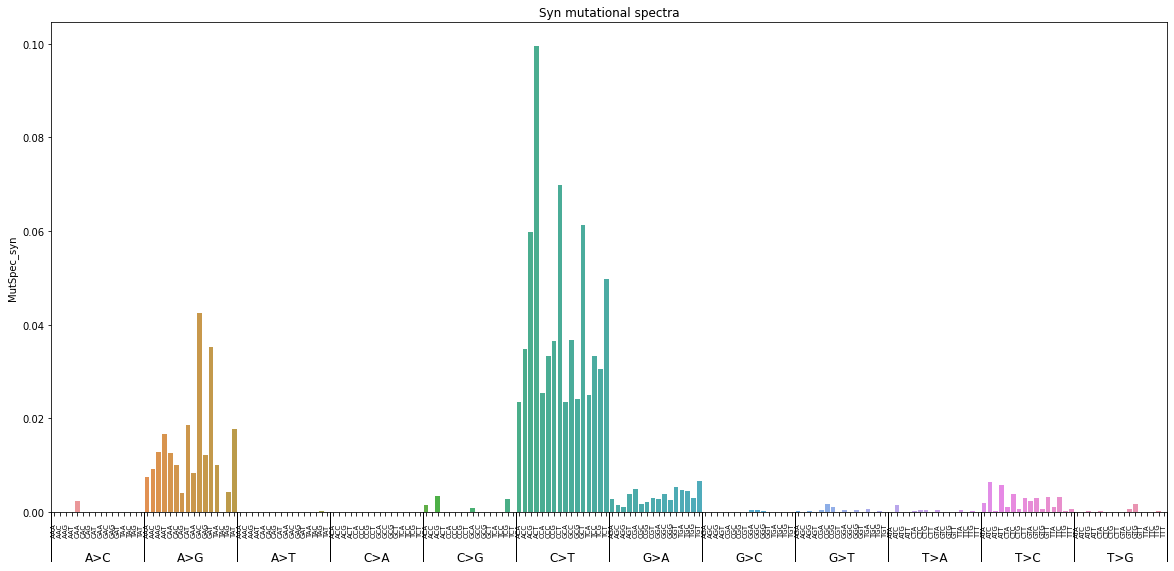

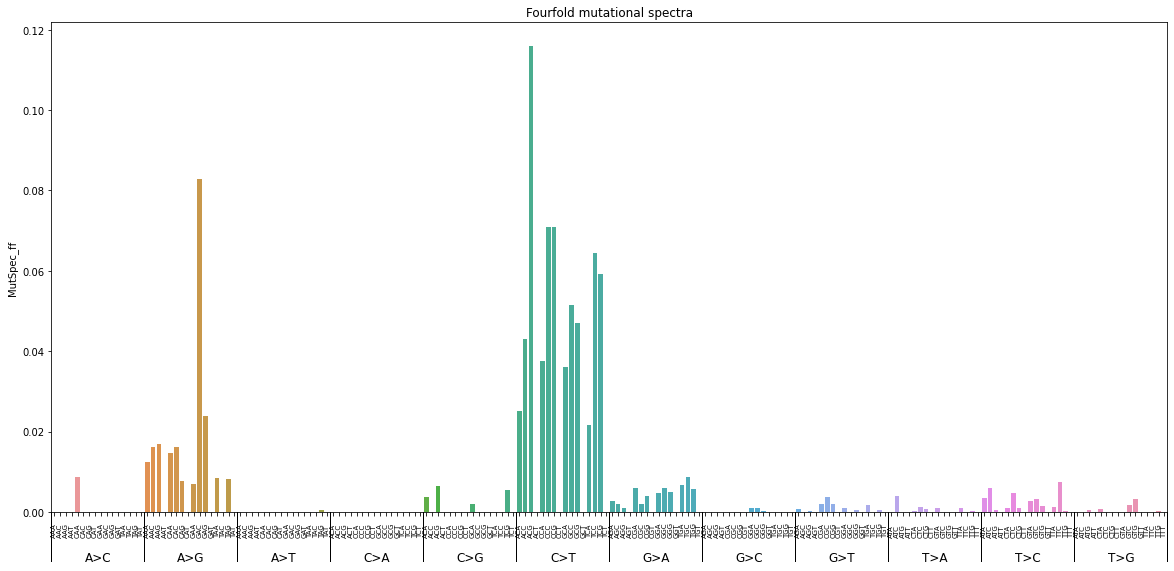

In [200]:
plot_mutspec192(mutspec192, "MutSpec_all", "Full mutational spectra")
plot_mutspec192(mutspec192, "MutSpec_syn", "Syn mutational spectra")
plot_mutspec192(mutspec192, "MutSpec_ff", "Fourfold mutational spectra")